In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from datasets import Value, ClassLabel, Features, Sequence
from collections import defaultdict
from huggingface_hub import login

This notebook convert raw JSONs of PIE and MAGPIE dataset to HuggingFace Dataset format for NER task. 

In [18]:
PATH_PIE = '../data/raw/PIE_annotations_all_v2.json'
PATH_MAGPIE = '../data/raw/magpie-corpus.jsonl'

SEED = 42

## Read data

In [19]:
pie_df = pd.read_json(PATH_PIE)
magpie_df = pd.read_json(PATH_MAGPIE, lines=True)

In [20]:
pie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2239 entries, 0 to 2238
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   sense_label          2239 non-null   object
 1   offsets              2239 non-null   object
 2   idiom                2239 non-null   object
 3   PIE_label            2239 non-null   object
 4   sentence_number      2239 non-null   int64 
 5   context              2239 non-null   object
 6   context_untokenized  2239 non-null   object
 7   document_id          2239 non-null   object
dtypes: int64(1), object(7)
memory usage: 140.1+ KB


In [21]:
magpie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56622 entries, 0 to 56621
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   confidence                       56622 non-null  float64
 1   context                          56622 non-null  object 
 2   document_id                      56622 non-null  object 
 3   genre                            56622 non-null  object 
 4   id                               56622 non-null  int64  
 5   idiom                            56622 non-null  object 
 6   judgment_count                   56622 non-null  int64  
 7   label                            56622 non-null  object 
 8   label_distribution               56622 non-null  object 
 9   non_standard_usage_explanations  56622 non-null  object 
 10  offsets                          56622 non-null  object 
 11  sentence_no                      56622 non-null  int64  
 12  split             

## Prepare PIE data

In [22]:
def tokenize_text(text: str, offsets: list[list[int]]=None) -> tuple[list[str], list[str]]:
    '''
    Apply word tokenization for input text and marked NER tokens. Each token in the source 
    line is assumed to be separated by a space. Code uses IOB format.
    Args:
        text (str): Input text
        offsets (list[list[int]]): comprehended list with start:end indecies of each NER in text
    Returns:
        word_tokens (list[str]): list of word tokens
        pie_tokens (list[str]): list of coresponded NER labels

    Example:
    text: 'The deal was negotiated behind closed doors .'    
    offsets: [[24, 30], [31, 37], [38, 44]]
    
    Example idiom is 'behind closed doors' and function output will be
    ['The', 'deal', 'was', 'negotiated', 'behind', 'closed', 'doors', '.']
    ['O', 'O', 'O', 'O', 'B-PIE', 'I-PIE', 'I-PIE', 'O']
    '''
    word_tokens = []
    pie_tokens = []
    start = 0

    is_first_pie_token = True

    if not offsets:
        word_tokens = text.split()
        pie_tokens = ['O'] * len(word_tokens)
        return word_tokens, pie_tokens

    for offset in offsets:
        offset_start = offset[0]
        offset_end = offset[1]

        # Add tokens before current offset
        substr = text[start:offset_start]
        substr_tokens = substr.split()
        word_tokens.extend(substr_tokens)
        pie_tokens.extend(['O'] * len(substr_tokens))

        # Add offset tokens
        substr = text[offset_start:offset_end]
        substr_tokens = substr.split()
        word_tokens.extend(substr_tokens)

        sbstr_pie_tokens = ['I-PIE'] * len(substr_tokens)
        if is_first_pie_token:
            sbstr_pie_tokens[0] = 'B-PIE'
            is_first_pie_token = False
        pie_tokens.extend(sbstr_pie_tokens)
        start = offset_end

    # Add the substring after the last offset
    substr = text[start:]
    substr_tokens = substr.split()
    word_tokens.extend(substr_tokens)
    pie_tokens.extend(['O'] * len(substr_tokens))

    return word_tokens, pie_tokens

Remove PIEs offsets from controversial objects. From docs:<br>
`PIE_label: label indicating whether this sentence contains the PIE in question ('y') or not ('n')`

For example 'They do this even though they may break the conventions from time to time .'
doesn't contain 'break even' idiom

In [23]:
pie_df['PIE_label'].value_counts()

n    1189
y    1050
Name: PIE_label, dtype: int64

In [24]:
pie_df.loc[pie_df['PIE_label'] == 'n', 'offsets'] = None 

Extract NERs

In [25]:
# take only 3-rd sentence with NER inside
pie_df['context_pie_only'] = pd.DataFrame(pie_df['context'].to_list())[2]

In [26]:
pie_df[['tokens', 'ner_tags']] = pie_df.apply(lambda x: tokenize_text(x.context_pie_only, x.offsets), 
             axis=1, result_type='expand')

Select only relevant features for final view 

In [27]:
pie_df['is_pie'] = pie_df['PIE_label'] == 'y'

In [28]:
pie_df = pie_df[['idiom', 'is_pie', 'tokens', 'ner_tags']]

In [29]:
pie_df.head()

,idiom,is_pie,tokens,ner_tags
0,all along,True,"[All, along, ,, as, I, reported, at, the, time...","[B-PIE, I-PIE, O, O, O, O, O, O, O, O, O, O, O..."
1,all along,False,"[You, will, have, received, a, copy, of, my, h...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,all over the place,True,"[Commandos, were, digging, in, all, over, the,...","[O, O, O, O, B-PIE, I-PIE, O, I-PIE, O]"
3,at sea,True,"[All, too, often, he, was, away, at, sea, on, ...","[O, O, O, O, O, O, B-PIE, I-PIE, O, O, O, O]"
4,at the end of the day,True,"[for, example, ,, when, it, is, 4, o'clock, in...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


## Prepare MAGPIE data

In [30]:
magpie_df.head(2)

,confidence,context,document_id,genre,id,idiom,judgment_count,label,label_distribution,non_standard_usage_explanations,offsets,sentence_no,split,variant_type
0,1.0,"[, , One can not come to terms with the past ,...",p39d1118,PMB,0,come to terms with,3,i,"{'?': 0.0, 'f': 0.0, 'i': 1.0, 'l': 0.0, 'o': ...",[],"[[12, 16], [17, 19], [20, 25], [26, 30]]",0,training,identical
1,1.0,[And there may be one or two other things we w...,J97,S meeting,1,call it a day,3,i,"{'?': 0.0, 'f': 0.0, 'i': 1.0, 'l': 0.0, 'o': ...",[],"[[9, 13], [14, 16], [19, 22]]",470,training,identical


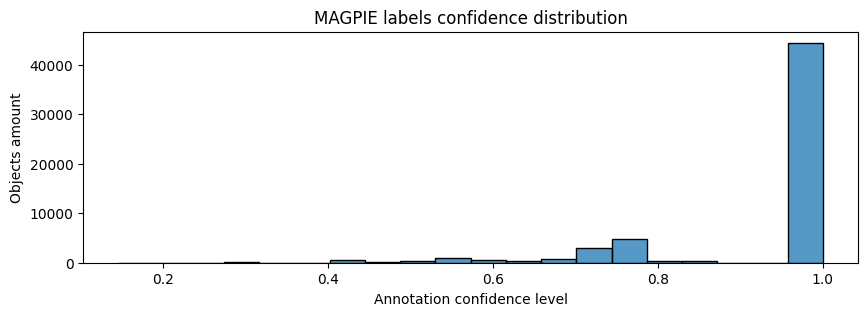

In [31]:
plt.figure(figsize=(10, 3))
plt.title('MAGPIE labels confidence distribution')
sns.histplot(magpie_df['confidence'], edgecolor='black', bins=20)
plt.xlabel('Annotation confidence level')
plt.ylabel('Objects amount')
plt.show()

Based on the analogy of the author of the corpus, we will use a threshold value of 75% confidence. 
In analogy with the PIE corpus, all examples with a value below the threshold will receive a False label.

In [32]:
magpie_df['is_pie'] = magpie_df['confidence'] > 0.75
magpie_df.loc[magpie_df['is_pie'] == False, 'offsets'] = None 

In [33]:
magpie_df['context_pie_only'] = pd.DataFrame(magpie_df['context'].to_list())[2]

In [34]:
magpie_df[['tokens', 'ner_tags']] = magpie_df.apply(lambda x: tokenize_text(x.context_pie_only, x.offsets), 
             axis=1, result_type='expand')

In [35]:
magpie_df = magpie_df[['idiom', 'is_pie', 'tokens', 'ner_tags']]

In [36]:
magpie_df.head()

,idiom,is_pie,tokens,ner_tags
0,come to terms with,True,"[One, can, not, come, to, terms, with, the, pa...","[O, O, O, B-PIE, I-PIE, I-PIE, I-PIE, O, O, O,..."
1,call it a day,True,"[We, might, call, it, a, day, at, the, end, of...","[O, O, B-PIE, I-PIE, O, I-PIE, O, O, O, O, O, ..."
2,out of the blue,True,"[‘, Well, ,, it, 's, a, recognised, symptom, o...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,full tilt,True,"[Taking, the, EG-1, first, ,, the, HFS, bridge...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,on paper,True,"[Generally, speaking, ,, re, -, sit, paper, er...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


## Convert DataFrames to HuggingFace Dataset

In [37]:
df = pd.concat([pie_df, magpie_df], ignore_index=True)

Remove duplicates

In [38]:
dupl_amount = df['tokens'].str.join(sep='').duplicated().sum()
print(f'Duplicates amount:{dupl_amount}')
print(f'Duplicates ratio {dupl_amount/len(df) :.3f}')


Duplicates amount:1691
Duplicates ratio 0.029


In [39]:
df = df.loc[~df['tokens'].str.join(sep='').duplicated(), :].reset_index(drop=True)

In [40]:
df.head()

,idiom,is_pie,tokens,ner_tags
0,all along,True,"[All, along, ,, as, I, reported, at, the, time...","[B-PIE, I-PIE, O, O, O, O, O, O, O, O, O, O, O..."
1,all along,False,"[You, will, have, received, a, copy, of, my, h...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,all over the place,True,"[Commandos, were, digging, in, all, over, the,...","[O, O, O, O, B-PIE, I-PIE, O, I-PIE, O]"
3,at sea,True,"[All, too, often, he, was, away, at, sea, on, ...","[O, O, O, O, O, O, B-PIE, I-PIE, O, O, O, O]"
4,at the end of the day,True,"[for, example, ,, when, it, is, 4, o'clock, in...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [41]:
df.to_csv('../data/processed/final_data.csv')

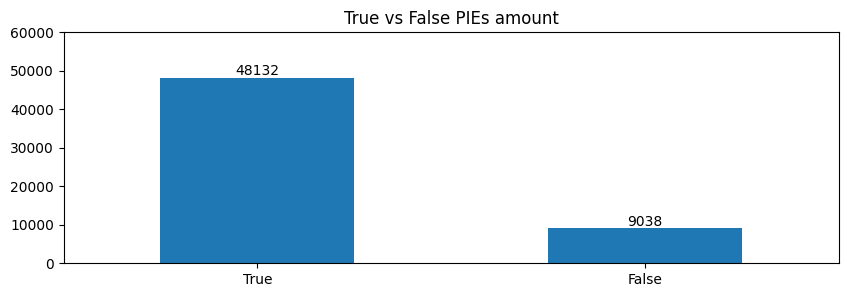

In [65]:
fig, ax = plt.subplots(figsize=(10, 3))
plt.title('True vs False PIEs amount')
df['is_pie'].value_counts().plot(kind='bar', ax=ax)
ax.bar_label(ax.containers[-1], label_type='edge')
plt.ylim([None, 60000])
plt.xticks(rotation=0)
plt.show()

Apply stratified split

In [43]:
train, valid_test = train_test_split(df, test_size=0.2, 
                                     stratify = df['is_pie'],
                                     shuffle=True, 
                                     random_state=SEED)

valid, test = train_test_split(valid_test, test_size=0.5, 
                                     stratify = valid_test['is_pie'],
                                     shuffle=True, 
                                     random_state=SEED)

In [44]:
len(train), len(valid), len(test)

(45736, 5717, 5717)

In [45]:
print(train['is_pie'].value_counts())
print(valid['is_pie'].value_counts())
print(test['is_pie'].value_counts())

True     38506
False     7230
Name: is_pie, dtype: int64
True     4813
False     904
Name: is_pie, dtype: int64
True     4813
False     904
Name: is_pie, dtype: int64


Define feature schema and create DatasetDict

In [46]:
features = Features({"idiom": Value("string"), 
                     "is_pie": Value("bool"),
                     "tokens": Sequence(Value('string')),
                     "ner_tags": Sequence(ClassLabel(num_classes=3, names=['O', 'B-PIE', 'I-PIE'])) })
                     

In [47]:
dataset_dict = DatasetDict()
dataset_dict['train'] = Dataset.from_pandas(train, features=features, preserve_index=False)
dataset_dict['validation'] = Dataset.from_pandas(valid, features=features, preserve_index=False)
dataset_dict['test'] = Dataset.from_pandas(test, features=features, preserve_index=False)

In [48]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['idiom', 'is_pie', 'tokens', 'ner_tags'],
        num_rows: 45736
    })
    validation: Dataset({
        features: ['idiom', 'is_pie', 'tokens', 'ner_tags'],
        num_rows: 5717
    })
    test: Dataset({
        features: ['idiom', 'is_pie', 'tokens', 'ner_tags'],
        num_rows: 5717
    })
})

In [49]:
dataset_dict['train'].features

{'idiom': Value(dtype='string', id=None),
 'is_pie': Value(dtype='bool', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PIE', 'I-PIE'], id=None), length=-1, id=None)}

Save locally and push to hub

In [50]:
dataset_dict.save_to_disk('../data/processed/pie_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/45736 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5717 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5717 [00:00<?, ? examples/s]

In [ ]:
# login()
# dataset_dict.push_to_hub("Gooogr/pie_idioms")